# Cell Averager

### Initial imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd

import os

In [2]:
ehooke = r"C:\Users\Antonio\Desktop\CA\eHooke_1.0-master"
sys.path.append(ehooke)

from images import ImageManager
from parameters import MaskParameters, RegionParameters, CellParameters, ParametersManager
from segments import SegmentsManager
from cells import CellManager
from cellcycleclassifier import CellCycleClassifier

from model import ExperimentalCondition, Replicate

You are using Python 3.6, which will no longer be supported in StarDist 0.9.0.
→ Please upgrade to Python 3.7 or later.
Using TensorFlow backend.


In [3]:
root_folder = r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2"  

for c in os.listdir(root_folder):
    cfolder = os.path.join(root_folder,c)
    if not os.path.isdir(cfolder):
        continue
        
    for fov in os.listdir(cfolder):
        fovfolder = os.path.join(cfolder,fov)
        if not os.path.isdir(fovfolder):
            continue
            
        for imgfile in os.listdir(fovfolder):
            if 'green' in imgfile and imgfile.endswith(".xml"):
                os.rename(os.path.join(fovfolder,imgfile),os.path.join(fovfolder,'green.xml'))
            elif 'red' in imgfile and imgfile.endswith(".xml"):
                os.rename(os.path.join(fovfolder,imgfile),os.path.join(fovfolder,'red.xml'))

In [4]:
def distance(p1,p2):
    # l2 norm
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def minpointdistance(points_1,points_2):
    
    mind = 1e12
    for i in points_1:
        for j in points_2:
            if i!=j:
                d = distance(i,j)
                if d<mind:
                    mind=d
    if mind!=1e12:
        return mind*0.08
    else:
        return None


In [5]:
for c in os.listdir(root_folder):
    
    condition_folder = os.path.join(root_folder,c)
    
    if os.path.exists(os.path.join(condition_folder,f"models_{c}.jpeg")):
        pass
        #print("skipping", c)
        #continue
    if not os.path.isdir(condition_folder):
        continue
        
    fluor1 = 'red'
    fluor2 = 'green'
    
    print(c, fluor1, fluor2)
    
    base = "membrane"
    membrane = 'membrane'
    basetype = "Membrane"
    dnaname = 'dna'
    
    exp_objects = ExperimentalCondition(condition_folder, fluor1, fluor2, membrane, base, basetype, dnaname)
    
    models_fluor_1 = exp_objects.askformodel(channel=1, modeltype='spot', minspots=1, cellcycle=(0,1,2,3))
    scatter_coords_1 = exp_objects.askforscatter(channel=1, minspots=1, maxspots=np.inf, cellcycle=(0,1,2,3))
    df_1 = exp_objects.askfortable(channel=1)
    
    if fluor2 != 'none':
        models_fluor_2 = exp_objects.askformodel(channel=2, modeltype='spot', minspots=1, cellcycle=(0,1,2,3))
        scatter_coords_2 = exp_objects.askforscatter(channel=2, minspots=1, maxspots=np.inf, cellcycle=(0,1,2,3))
        df_2 = exp_objects.askfortable(channel=2)
    else:
        models_fluor_2 = 0,0,0,np.zeros((30,30))
        scatter_coords_2 = [],[]
    
    # merge dfs
    if fluor2 != 'none':
        finaldf = pd.merge(df_1,df_2)
    else:
        finaldf = df_1
        
    # build mindistances
    mind11 = []
    mind12 = []
    mind22 = []
    for index,row in finaldf.iterrows():
        sp1 = row['SpotCoords_1']

        # 1 to 1
        mind11.append(minpointdistance(sp1,sp1))

        try:
            sp2 = row['SpotCoords_2']
            # 1 to 2
            mind12.append(minpointdistance(sp1,sp2))
            mind22.append(minpointdistance(sp2,sp2))
        except:
            pass

    finaldf['MinDistance_1to1'] = mind11

    try:
        finaldf['MinDistance_1to2'] = mind12
        finaldf['MinDistance_2to2'] = mind22
    except:
        pass
    
    ### THIS IS JUST WHEN WE HAVE 2 CHANNELS ###
    closest1to2 = []
    closest2to1 = []
    for index,row in finaldf.iterrows():
        arr1to2 = []
        arr2to1 = []
        sp1 = row['SpotCoords_1']
        sp2 = row['SpotCoords_2']

        for spot1 in sp1:
            distances = [distance(spot1,spot2)*0.08 for spot2 in sp2]
            try:
                arr1to2.append(min(distances))
            except ValueError:
                arr1to2.append(np.nan)

        for spot2 in sp2:
            distances = [distance(spot1,spot2)*0.08 for spot1 in sp1]
            try:
                arr2to1.append(min(distances))
            except ValueError:
                arr2to1.append(np.nan)

        closest1to2.append(arr1to2)
        closest2to1.append(arr2to1)

    finaldf["ClosestDistance1to2"] = closest1to2
    finaldf["ClosestDistance2to1"] = closest2to1
    
    fig,ax = plt.subplots(1,1,dpi=300)
    sns.displot(data=finaldf.explode("ClosestDistance1to2").reset_index(drop=True),x='ClosestDistance1to2',ax=ax,hue='CCP',stat='count',discrete=False,alpha=0.3,palette="bright")
    plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"closestdistances1to1_{c}.jpeg"))

    fig,ax = plt.subplots(1,1,dpi=300)
    sns.displot(data=finaldf.explode("ClosestDistance2to1").reset_index(drop=True),x='ClosestDistance2to1',ax=ax,hue='CCP',stat='count',discrete=False,alpha=0.3,palette="bright")
    plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"closestdistances2to1_{c}.jpeg"))

    ### END ###
     
    # save finaldf
    finaldf.to_csv(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"results_{c}.csv"))
        
    # totalN, totalCells, totalSpots, final_model
    
    fig, ax = plt.subplots(3, 2, dpi=300)
    
    ax[0,0].imshow(models_fluor_1[3], cmap='coolwarm')
    ax[0,1].imshow(models_fluor_2[3], cmap='coolwarm')
    ax[0,0].axis('off')
    ax[0,1].axis('off')
    ax[0,0].set_title(f"{fluor1}->=1 spot cells", fontsize=4)
    ax[0,1].set_title(f"{fluor2}->=1 spot cells", fontsize=4)
    
    #ax[1,0].plot(scatter_coords_1[0],scatter_coords_1[1],'x')
    #ax[1,1].plot(scatter_coords_2[0],scatter_coords_2[1],'x')
    ax[1,0].axis('off')
    ax[1,1].axis('off')
    ax[1,0].set_title(f"{fluor1}->=1 spot cells", fontsize=4)
    ax[1,1].set_title(f"{fluor2}->=1 spot cells", fontsize=4)
    
    
    rawtxt = f"Total cells={models_fluor_1[1]} \n Cells with at least 1 spot={models_fluor_1[0]} \n Total spots={models_fluor_1[2]}"
    ax[2,0].axis([0,10,0,10])
    ax[2,0].axis('off')
    ax[2,0].text(5,5,rawtxt, fontsize=5, wrap=True)
    
    rawtxt = f"Total cells={models_fluor_2[1]} \n Cells with at least 1 spot={models_fluor_2[0]} \n Total spots={models_fluor_2[2]}"
    ax[2,1].axis([0,10,0,10])
    ax[2,1].axis('off')
    ax[2,1].text(5,5,rawtxt, fontsize=5, wrap=True)
    
    plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"models_{c}.jpeg"))
    plt.close('all')
    
    fig,ax = plt.subplots(1,1,dpi=300)
    sns.displot(data=finaldf,x='Nspots_1',hue='CCP',ax=ax,stat='count',discrete=True,alpha=0.3,palette="bright")
    plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"histogram1_{c}.jpeg"))
    
    fig,ax = plt.subplots(1,1,dpi=300)
    sns.displot(data=finaldf,x='MinDistance_1to1',hue='CCP',ax=ax,stat='count',discrete=False,alpha=0.3,palette="bright")
    plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"distances1to1_{c}.jpeg"))
    
    try:
        fig,ax = plt.subplots(1,1,dpi=300)
        sns.displot(data=finaldf,x='Nspots_2',hue='CCP',ax=ax,stat='count',discrete=True,alpha=0.3,palette="bright")
        plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"histogram2_{c}.jpeg"))

        fig,ax = plt.subplots(1,1,dpi=300)
        sns.displot(data=finaldf,x='MinDistance_1to2',hue='CCP',ax=ax,stat='count',discrete=False,alpha=0.3,palette="bright")
        plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"distances1to2_{c}.jpeg"))

        fig,ax = plt.subplots(1,1,dpi=300)
        sns.displot(data=finaldf,x='MinDistance_2to2',hue='CCP',ax=ax,stat='count',discrete=False,alpha=0.3,palette="bright")
        plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"distances2to2_{c}.jpeg"))
    except:
        pass
    
    plt.close('all')

ori-mNG_ricO-SNAPJF549_1 red green
ori-mNG_ricO-SNAPJF549_2 red green
ori-mNG_ricO-SNAPJF549_3 red green


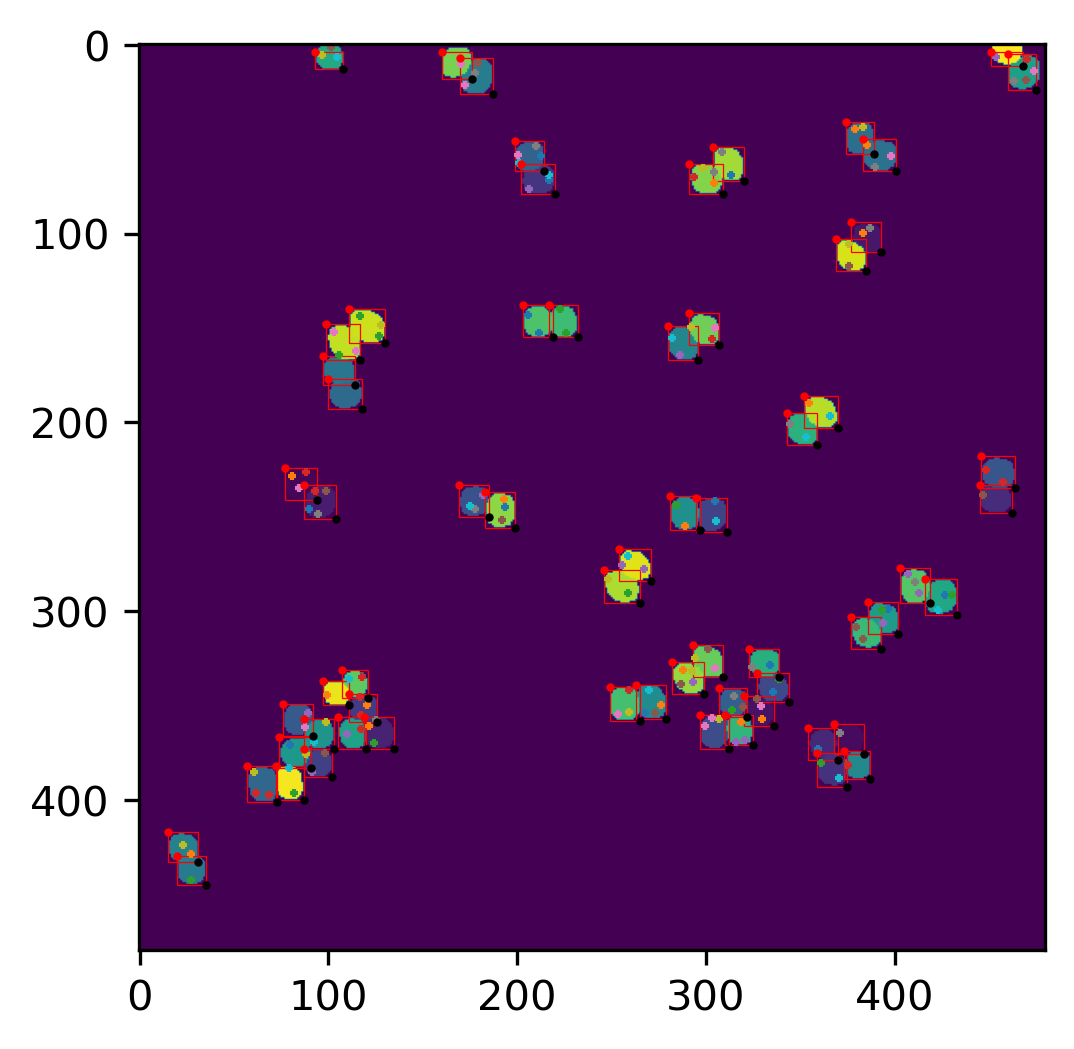

In [6]:
from matplotlib.patches import Rectangle

plt.figure(dpi=300)
ax = plt.gca()

plt.imshow(exp_objects.replicates[0].imagemanager[0].stardist_labels)
for spot in exp_objects.replicates[0].cellmodeler[0].spots.allspots:
    plt.plot(float(spot.attrib['POSITION_X']) / 0.08,float(spot.attrib['POSITION_Y']) / 0.08,'+',markersize=2)
    #plt.xlim((0,480))
    #plt.ylim((0,480))
    
for key in exp_objects.replicates[0].cellmanager[0].cells:
    #if exp_objects.replicates[0].cellmanager[0].cells[key].axis_ratio:

    box = exp_objects.replicates[0].cellmanager[0].cells[key].box
    
    box = (box[0]+4,box[1]+4,box[2]-4,box[3]-4)
    
    rect = Rectangle((box[1],box[0]),box[3]-box[1],box[2]-box[0],fill=False,edgecolor='red',linewidth=0.3)
    ax.add_patch(rect)
    plt.plot(box[1],box[0],'ro', markersize=1)
    plt.plot(box[3],box[2],'ko',markersize=1)
    
plt.savefig(os.path.join(r"C:\\Users\\Antonio\\Desktop\\heatmaps_fros\\2024-6-14_foci-count_2_results",f"testing_qc.jpeg"))